[Reference](https://riazuddin1985.medium.com/time-series-pattern-matching-with-stock-prices-7b86d8303e9e)

# Step 1 — Install and Import Libraries



In [1]:
#Install Libraries
!pip install pytictoc
!pip install yahoo_fin
!pip install stumpy
#Importing Libraries
import pandas as pd
import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
from pytictoc import TicToc
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
t=TicToc()
import stumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.3 MB/s 
     |████████████████████████████████| 83 kB 1.6 MB/s 
     |████████████████████████████████| 127 kB 55.2 MB/s 
     |████████████████████████████████| 112 kB 45.6 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=6c3f13607c80852231c5abae4a25b5f6d2ea60373ffbc0a91f2d5f2f1fce9e5a
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=9252c4a38780303f2e7f55e13f5b39bba253e59af8e658b1d49e8c5cd7e473ef
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgml

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


# Step 2— Importing and Preparing the Data



In [2]:
#Defining Start and End Date
end_date = date.today().strftime('%m/%d/%Y')
start_date = '01/01/1950'
#Importing Data
spx_all =si.get_data('^GSPC' , start_date = start_date , end_date = end_date)["close"].to_frame().round(1)
spx_all.head()

,close
1950-01-03,16.7
1950-01-04,16.9
1950-01-05,16.9
1950-01-06,17.0
1950-01-09,17.1


In [3]:
#Adding Moving Averages
from pandas.core import window
spx_all["5DMA"] = spx_all["close"].rolling(5).mean().round(1)
spx_all["30DMA"] = spx_all["close"].rolling(30).mean().round(1)
spx_all = spx_all.dropna()

In [4]:
#Partitioning the data
sel_start = date(2021,1,1)
spx_sel = spx_all[sel_start:end_date]
print(spx_sel.head())
spx_past = spx_all[:sel_start]
print(spx_past.tail())

             close    5DMA   30DMA
2021-01-04  3700.6  3730.2  3674.6
2021-01-05  3726.9  3728.5  3679.5
2021-01-06  3748.1  3732.7  3685.8
2021-01-07  3803.8  3747.1  3693.4
2021-01-08  3824.7  3760.8  3699.7
             close    5DMA   30DMA
2020-12-24  3703.1  3696.9  3650.5
2020-12-28  3735.4  3702.1  3657.1
2020-12-29  3727.0  3708.6  3661.8
2020-12-30  3732.0  3717.5  3665.3
2020-12-31  3756.1  3730.7  3670.2


# Step 3 — Match Making



In [5]:
#Calculating distance profile
distance_profile = stumpy.mass(spx_sel["5DMA"], spx_past["5DMA"],normalize=True)
#Getting index position with the minimum distance score
idx = np.argmin(distance_profile)
print(f"The nearest neighbor to `spx_sel` is located at index {idx} in `spx_past`")
print(f"The period between {str(spx_past.iloc[idx].name.strftime('%m/%d/%Y'))} and {str(spx_past.iloc[idx+len(spx_sel)].name.strftime('%m/%d/%Y'))} is most similar to selected pattern")

The nearest neighbor to `spx_sel` is located at index 7583 in `spx_past`
The period between 05/05/1980 and 02/02/1982 is most similar to selected pattern


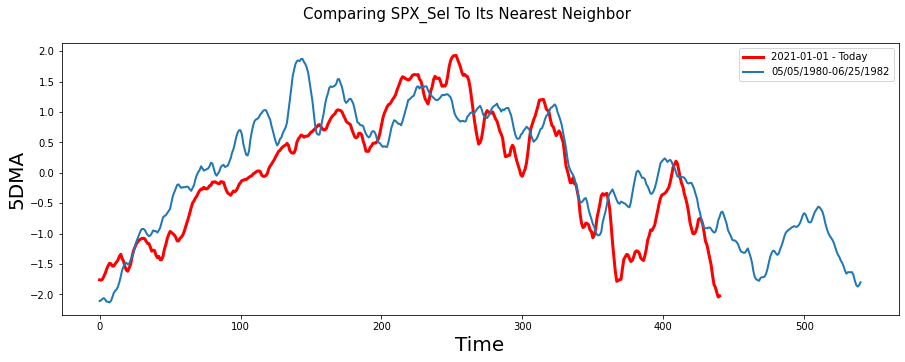

In [6]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
spx_sel_z_norm = stumpy.core.z_norm(spx_sel["5DMA"].values)
add = 100
spx_past_z_norm = stumpy.core.z_norm(spx_past["5DMA"].values[idx:idx+len(spx_sel)+add])
plt.figure(figsize=(15,5))
plt.suptitle('Comparing SPX_Sel To Its Nearest Neighbor', fontsize='15')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('5DMA', fontsize='20')
plt.plot(spx_sel_z_norm, lw=3, color="red", label=str(sel_start)+" - Today")
plt.plot(spx_past_z_norm, lw=2, label=str(spx_past.iloc[idx].name.strftime('%m/%d/%Y'))+"-" +str(spx_past.iloc[idx+len(spx_sel)+add].name.strftime('%m/%d/%Y')))
plt.legend()
plt.show()

# Step 4 — Look at other competing matches



In [7]:
#Top 10 matches
matches = stumpy.match(spx_sel["5DMA"],spx_past["5DMA"],max_matches=10,normalize= True)
matches_df= pd.DataFrame(matches, columns=["Score","Position"])
a=[]
for i in matches_df["Position"]:
  x = spx_past.iloc[i].name.strftime('%m/%d/%Y')
  a.append(x)
matches_df["Match_Start_Dates"]= a
matches_df["Norm_Score"] = (matches_df["Score"]-matches_df["Score"].mean())/matches_df["Score"].std()
matches_df

,Score,Position,Match_Start_Dates,Norm_Score
0,11.068949,7583,05/05/1980,-1.64151
1,11.947046,14240,09/19/2006,-1.057578
2,11.954047,2734,01/03/1961,-1.052922
3,13.155568,4495,01/02/1968,-0.253914
4,13.489238,5472,12/23/1971,-0.032025
5,13.802157,8213,11/01/1982,0.176065
6,14.424098,2151,09/09/1958,0.589655
7,14.865538,9149,07/16/1986,0.883211
8,15.313271,1376,08/11/1955,1.180952
9,15.354046,492,02/04/1952,1.208067
